In [1]:
from sirf.STIR import (ImageData, AcquisitionData,
                       SPECTUBMatrix, AcquisitionModelUsingMatrix,
                       MessageRedirector, TruncateToCylinderProcessor)
from simind import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

msg = MessageRedirector()
AcquisitionData.set_storage_scheme('memory')

In [2]:
# SIMIND parameters
total_activity = 187 # MBq
time_per_projection = 20  # seconds
photon_multiplier = 1 # number of photons simulated is calculated based on source map. This number multiplies the calculated number of photons
photopeak_energy = 150  # keV
window_lower = 75 # keV
window_upper = 225 # keV
source_type = "y90" 
collimator = 'ma-megp' 
kev_per_channel = 25 # keV
num_energy_spectra_channels = 2280//kev_per_channel # number of energy spectra channels

In [3]:
image = ImageData("/home/sam/data/phantom_data/SPECT/ellipsoid_image_s.hv")
mu_map = ImageData("/home/sam/data/phantom_data/SPECT/umap_zoomed.hv")
measured_data = AcquisitionData("/home/sam/data/phantom_data/SPECT/peak_1_projdata__f1g1d0b0.hs")

#image = ImageData("/home/sam/working/BSREM_PSMR_MIC_2024/results/both/subsets/cpu_prior_kappa/d_iter_1/svrg/bsrem_modality_1_a_0.0001_b_0.0005.hv")
#mu_map = ImageData("/home/sam/data/anthropomorphic_Y90/phantom/SPECT/umap_zoomed.hv")
#measured_data = AcquisitionData("/home/sam/data/anthropomorphic_Y90/phantom/SPECT/peak_en_1_90_Yttrium.hdr")

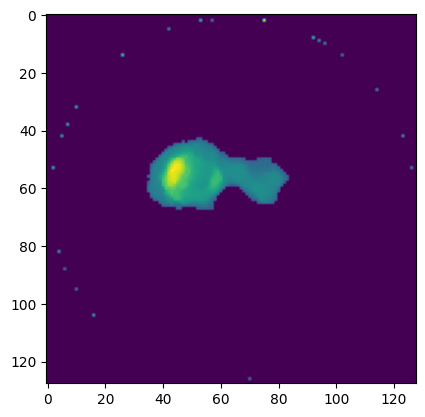

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(image.as_array()[64,:,:])

def threshold_iamge_by_percentile(image, percentile):
    res = image.clone()
    threshold = np.percentile(image.as_array(), percentile)
    array = np.where(image.as_array() > threshold, image.as_array(), 0)
    res.fill(array)
    return res

image = threshold_iamge_by_percentile(image, 99)
cyl = TruncateToCylinderProcessor()
cyl.set_strictly_less_than_radius(True)
cyl.apply(image)

plt.imshow(image.as_array()[64,:,:])

In [5]:
## Unfortunately this is necessary due to a bug in STIR

mu_map_stir = mu_map.clone()
mu_map_stir.fill(np.flip(mu_map.as_array(), axis=2))

In [6]:
output_dir = "/home/sam/working/STIR_users_MIC2023/simind_output"
# clear output dir if it exists
import shutil
shutil.rmtree(output_dir, ignore_errors=True)
import os
os.makedirs(output_dir, exist_ok=True)

In [7]:
os.chdir("/home/sam/working/STIR_users_MIC2023")
# set up the simulator
simulator = SimindSimulator(template_smc_file_path="/home/sam/working/STIR_users_MIC2023/input.smc", 
                            output_dir=output_dir, source=image,
                            mu_map=mu_map_stir, template_sinogram=measured_data)

In [8]:
# Set the parameters for the simulation
simulator.add_comment("Testing for MIC2023")
simulator.set_windows(window_lower, window_upper, 0)
simulator.add_index("photon_energy", photopeak_energy)
simulator.add_index("scoring_routine", 1) # scattwin scoring routine
simulator.add_index("collimator_routine", 1) # septal penetration routine (slower)
simulator.add_index("photon_direction", -90) # model septal penetration for all angles
simulator.add_index("source_activity", total_activity*time_per_projection)
simulator.add_index("kev_per_channel", kev_per_channel)
simulator.add_index("energy_spectra_channels", num_energy_spectra_channels)
simulator.add_index("cutoff_energy_terminate_photon_history", window_lower*0.75) # keV
# resolutin
simulator.add_index("energy_resolution", 9.5) # percent
simulator.add_index("intrinsic_resolution", 0.31) # cm
# crystal dimensions
simulator.add_index("crystal_thickness", 15.9/10) #cm
simulator.add_index("crystal_half_length_radius", 470/2/10) # cm
simulator.add_index("crystal_half_width", 585/2/10)
simulator.add_index("step_size_photon_path_simulation", min(*image.voxel_sizes())/10) # cm
simulator.config.set_flag(11, True)
simulator.config.set_flag(7, True)

In [9]:
simulator.config.print_config()

Comment: Testing for MIC2023
Basic Change data:
index 1: photon_energy: 150
index 2: source_half_length: 27.249920654296876
index 3: source_half_width: 27.249920654296876
index 4: source_half_height: 27.249920654296876
index 5: phantom_half_length: 27.249920654296876
index 6: phantom_half_width: 27.249920654296876
index 7: phantom_half_height: 27.249920654296876
index 8: crystal_half_length_radius: 23.5
index 9: crystal_thickness: 1.59
index 10: crystal_half_width: 29.25
index 11: backscattering_material_thickness: 10.0
index 12: height_to_detector_surface: 30.0
index 13: cover_thickness: 0.12
index 14: phantom_type: -1
index 15: source_type: -1
index 16: shift_source_x: 0.0
index 17: shift_source_y: 0.0
index 18: shift_source_z: 0.0
index 19: photon_direction: -90
index 20: upper_window_threshold: -100.0
index 21: lower_window_threshold: -100.0
index 22: energy_resolution: 9.5
index 23: intrinsic_resolution: 0.31
index 24: emitted_photons_per_decay: 0.879
index 25: source_activity: 74

In [10]:
simulator.runtime_switches.print_available_switches()

Switches for {'CC': 'Collimator code', 'DF': 'Density file segment', 'ES': 'Energy offset', 'FE': 'Energy resolution file', 'FZ': 'Zubal file', 'FI': 'Input file', 'FD': 'Density map base name', 'FS': 'Source map base name', 'I2': 'Image files stored as 16-bit integer matrices', 'IN': 'Change simind.ini value', 'LO': 'Photon histories before printout', 'LF': 'Linear sampling of polar angle for photon direction', 'MP': 'MPI parallel run', 'OR': 'Change orientation of the density map', 'PR': 'Start simulation at projection number', 'PU': 'Shift of the source in pixel units', 'QF': 'Quit simulation if earlier result file exists', 'RR': 'Random number generator seed', 'SC': 'Maximum number of scatter orders', 'SF': 'Segment for source map', 'TS': 'Time shift for interfile header', 'UA': 'Set density equal to data buffer or 1.0', 'WB': 'Whole-body simulation of anterior and posterior views', 'Xn': 'Change cross sections'}:
CC: Collimator code
DF: Density file segment
ES: Energy offset
FE: E

In [11]:

# Set the runtime switches
simulator.add_runtime_switch("CC", collimator) # which collimator
simulator.add_runtime_switch("NN", photon_multiplier) # multiplier for number of photons simulated
simulator.add_runtime_switch("FI", source_type) # source type (Y90 in this case)
simulator.add_runtime_switch("SC", 5) # force simulation to run

In [12]:
simulator.run_simulation()

Updating path strings for linux
Running simind with command: simind /home/sam/working/STIR_users_MIC2023/simind.smc /home/sam/working/STIR_users_MIC2023/simind_output/output /PX:0.4257800102233887/TH:0.4257800102233887/NN:0.001/CC:ma-megp/FI:y90/SC:5


 



              SIMIND Monte Carlo Simulation Program    V8.0  
------------------------------------------------------------------------------
 Phantom S : h2o       Crystal...: nai       InputFile.: simind            
 Phantom B : bone      BackScatt.: pmt       OutputFile: simind            
 Collimator: pb_sb2    SourceRout: smap      SourceImg.: tmp_source        
 Cover.....: al        ScoreRout.: scattwin  DensityImg: tmp_density       
------------------------------------------------------------------------------
 PhotonEnergy.......: 150          y90       PhotonsPerProj....: 327736         
 EnergyResolution...: 9.5          Spectra   Activity..........: 7480           
 MaxScatterOrder....: 10           ma-megp   DetectorLenght....: 23.5           
 DetectorWidth......: 29.25        SPECT     DetectorHeight....: 1.59           
 UpperEneWindowTresh: 225          BScatt    Distance to det...: 30             
 LowerEneWindowTresh: 75           Random    ShiftSource X.....: 0

In [13]:
simulator.get_output()

Output in /home/sam/working/STIR_users_MIC2023/simind_output/simind_tot_w1.hs
Output in /home/sam/working/STIR_users_MIC2023/simind_output/simind_sca_w1.hs
Output in /home/sam/working/STIR_users_MIC2023/simind_output/simind_air_w1.hs
Output in /home/sam/working/STIR_users_MIC2023/simind_output/simind_sca_w2.hs


{'sca_w1': <sirf.STIR.AcquisitionData at 0x7fd1c21aaaa0>,
 'tot_w1': <sirf.STIR.AcquisitionData at 0x7fd1c21aa9b0>,
 'air_w1': <sirf.STIR.AcquisitionData at 0x7fd1c21aac20>}

In [14]:
simind_total = simulator.get_output_total()
simind_scatter = simulator.get_output_scatter()
simind_true = simind_total - simind_scatter

simind_total.write("data/Y90/simind_total_ellipses_megp_cpd.hs")
simind_scatter.write("data/Y90/simind_scatter_ellipses_megp_cpd.hs")
simind_true.write("data/Y90/simind_true_ellipses_megp_cpd.hs")

In [15]:
acq_matrix = SPECTUBMatrix()
acq_matrix.set_attenuation_image(mu_map_stir)
acq_matrix.set_keep_all_views_in_cache(True)
acq_matrix.set_resolution_model(1.81534, 0.02148, False)
acq_model = AcquisitionModelUsingMatrix(acq_matrix)
acq_model.set_up(measured_data, image)


INFO: Setting attenuation type to 'simple'

INFO: 2D PSF Correction. Parallel geometry

Parameters of SPECT UB matrix: (in cm)
Image grid side row: 128	col: 128	transverse voxel_size: 0.42578
Number of slices: 128	slice_thickness: 0.42578
Number of bins: 128	bin size: 0.42578	axial size: 0.42578
Number of angles: 120	Angle increment: 3	First angle: 360
Number of subsets: 120
Correction for attenuation: 		do_msk_att: 0
Attenuation map: 
Rotation radii: {30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30}
Minimum weight: 0


INFO: Done estimating size of matrix. Exec

In [16]:
stir_forward_projection = acq_model.forward(image)


INFO: Computing matrix elements for view 6

INFO: total number of non-zero weights in this view: 17248768, estimated size: 166.06 MB

INFO: Weight matrix calculation done. time 0.95 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 1.07 (s)

INFO: Computing matrix elements for view 14

INFO: total number of non-zero weights in this view: 16690304, estimated size: 160.734 MB

INFO: Weight matrix calculation done. time 1.01 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 1.13 (s)

INFO: Computing matrix elements for view 4

INFO: total number of non-zero weights in this view: 17544960, estimated size: 168.884 MB

INFO: Weight matrix calculation done. time 1.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 1.16 (s)

INFO: Computing matrix elements for view 5

INFO: total number of non-zero weights in this view: 17387776, estimated size: 167.385 MB

INFO: Weight matrix calculation done. time 1.03 (s)

INFO: Tota

In [17]:
scaling_factor_stir = stir_forward_projection.sum()/simind_true.sum()
scaling_factor_measured = measured_data.sum()/simind_total.sum()

scaling_factor = scaling_factor_measured

In [18]:
print(f"stir scaling factor: {scaling_factor_stir}")
print(f"measured scaling factor: {scaling_factor_measured}")

stir scaling factor: 0.25263628363609314
measured scaling factor: 0.9976202845573425


In [19]:
print(f"simind unnormalised total counts: {simind_total.sum()}")
print(f"simind unnormalised true counts: {simind_true.sum()}")
print(f"simind unnormalised scatter counts: {simind_scatter.sum()}")
print("\n")
print(f"simind normalised total counts: {simind_total.sum()*scaling_factor}")
print(f"simind normalised true counts: {simind_true.sum()*scaling_factor}")
print(f"simind normalised scatter counts: {simind_scatter.sum()*scaling_factor}")
print("\n")
print(f"measured total counts: {measured_data.sum()}")
print(f"stir total counts: {stir_forward_projection.sum()}")

simind unnormalised total counts: 3792052.0
simind unnormalised true counts: 2423257.25
simind unnormalised scatter counts: 1368794.875


simind normalised total counts: 3783028.0
simind normalised true counts: 2417490.5
simind normalised scatter counts: 1365537.5


measured total counts: 3783028.0
stir total counts: 612202.6875


In [23]:
data_list = [
    ((simind_total).as_array(), "SIMIND total"),
    (measured_data.as_array(), "measured"),
    ((simind_true).as_array(), "SIMIND true"),
    ((stir_forward_projection).as_array(), "STIR forward"),
    ((simind_scatter).as_array(), "SIMIND scatter"),
]

axial_slice = 64

print([data.shape for data, _ in data_list])

vmax = max([data[0][axial_slice].max() for data, _ in data_list])/1.2

[(1, 128, 120, 128), (1, 128, 120, 128), (1, 128, 120, 128), (1, 128, 120, 128), (1, 128, 120, 128)]


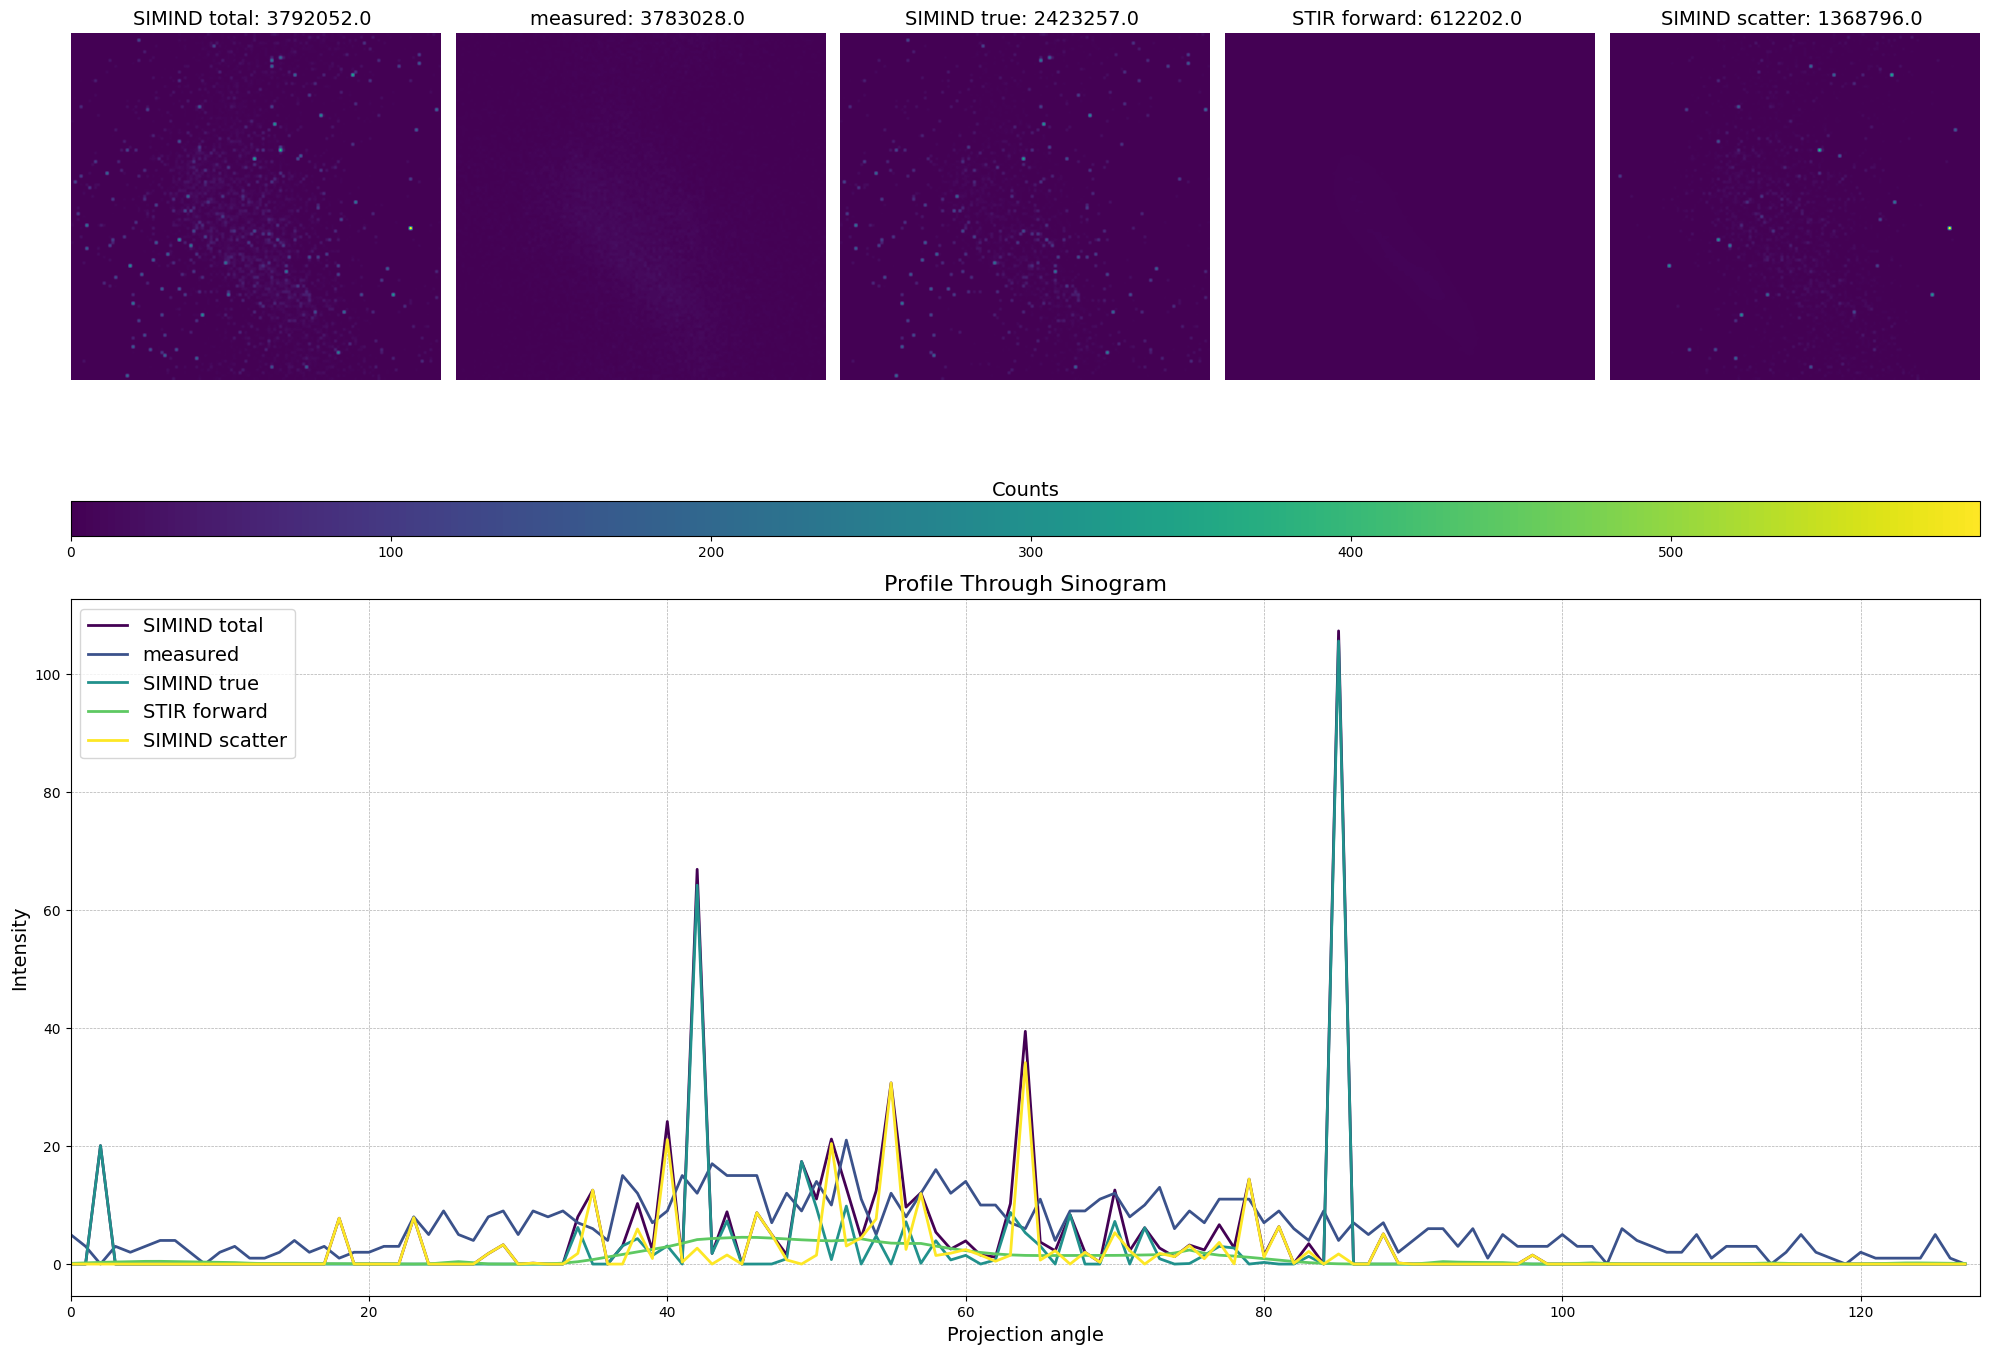

In [24]:
# Define consistent font size and colormap
font_size = 14
colormap = 'viridis'

divisors = [1, 1, 1, scaling_factor_stir*8, 1]

# Create a figure and a GridSpec with 3 rows
fig = plt.figure(figsize=(len(data_list)*4,7*2,))
gs = GridSpec(3, len(data_list), height_ratios=[2, 0.15, 3])  # Adjusted GridSpec for clarity

# Create image subplots in the first row
ax_images = [fig.add_subplot(gs[0, i]) for i in range(len(data_list))]

for i, (data, title) in enumerate(data_list):
    im = ax_images[i].imshow(data[0, axial_slice]/divisors[i], vmin=0, vmax=vmax, cmap=colormap)
    ax_images[i].set_title(f"{title}: {np.trunc(data.sum())} ", fontsize=font_size)
    ax_images[i].axis('off')

# Place a colorbar in a new row, just for the colorbar
cbar_ax = fig.add_subplot(gs[1, :])  # Spanning across the bottom of the image plots
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=0.02)  # Reduced padding
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.xaxis.set_label_position('top')

# Set consistent font size and line width for the line plot
line_width = 2

# Create line plot in the third row
ax_line = fig.add_subplot(gs[2, :])  # Spanning across both columns in the third row

# Plotting
# make colours eqwually spread out with length of data_list
colours = plt.cm.viridis(np.linspace(0, 1, len(data_list)))
for i, (data, title) in enumerate(data_list):
    #ax_line.plot(data[40], label=title, linewidth=line_width, color=colours[i], linestyle='--')
    ax_line.plot(data[0, axial_slice][60]/divisors[i], linewidth=line_width, color=colours[i], linestyle='-', label=title)
    #ax_line.plot(data[90], linewidth=line_width, color=colours[i], linestyle=':')

# Enhance the appearance of the line plot
ax_line.set_xlabel('Projection angle', fontsize=font_size)
ax_line.set_ylabel('Intensity', fontsize=font_size)
ax_line.set_title(f'Profile Through Sinogram', fontsize=font_size + 2)
ax_line.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_line.legend(loc='upper left', fontsize=font_size)
# et minimum and maximum values for x-axis
ax_line.set_xlim(0, 128)

# Adjust spacing and layout
plt.tight_layout()
plt.show()

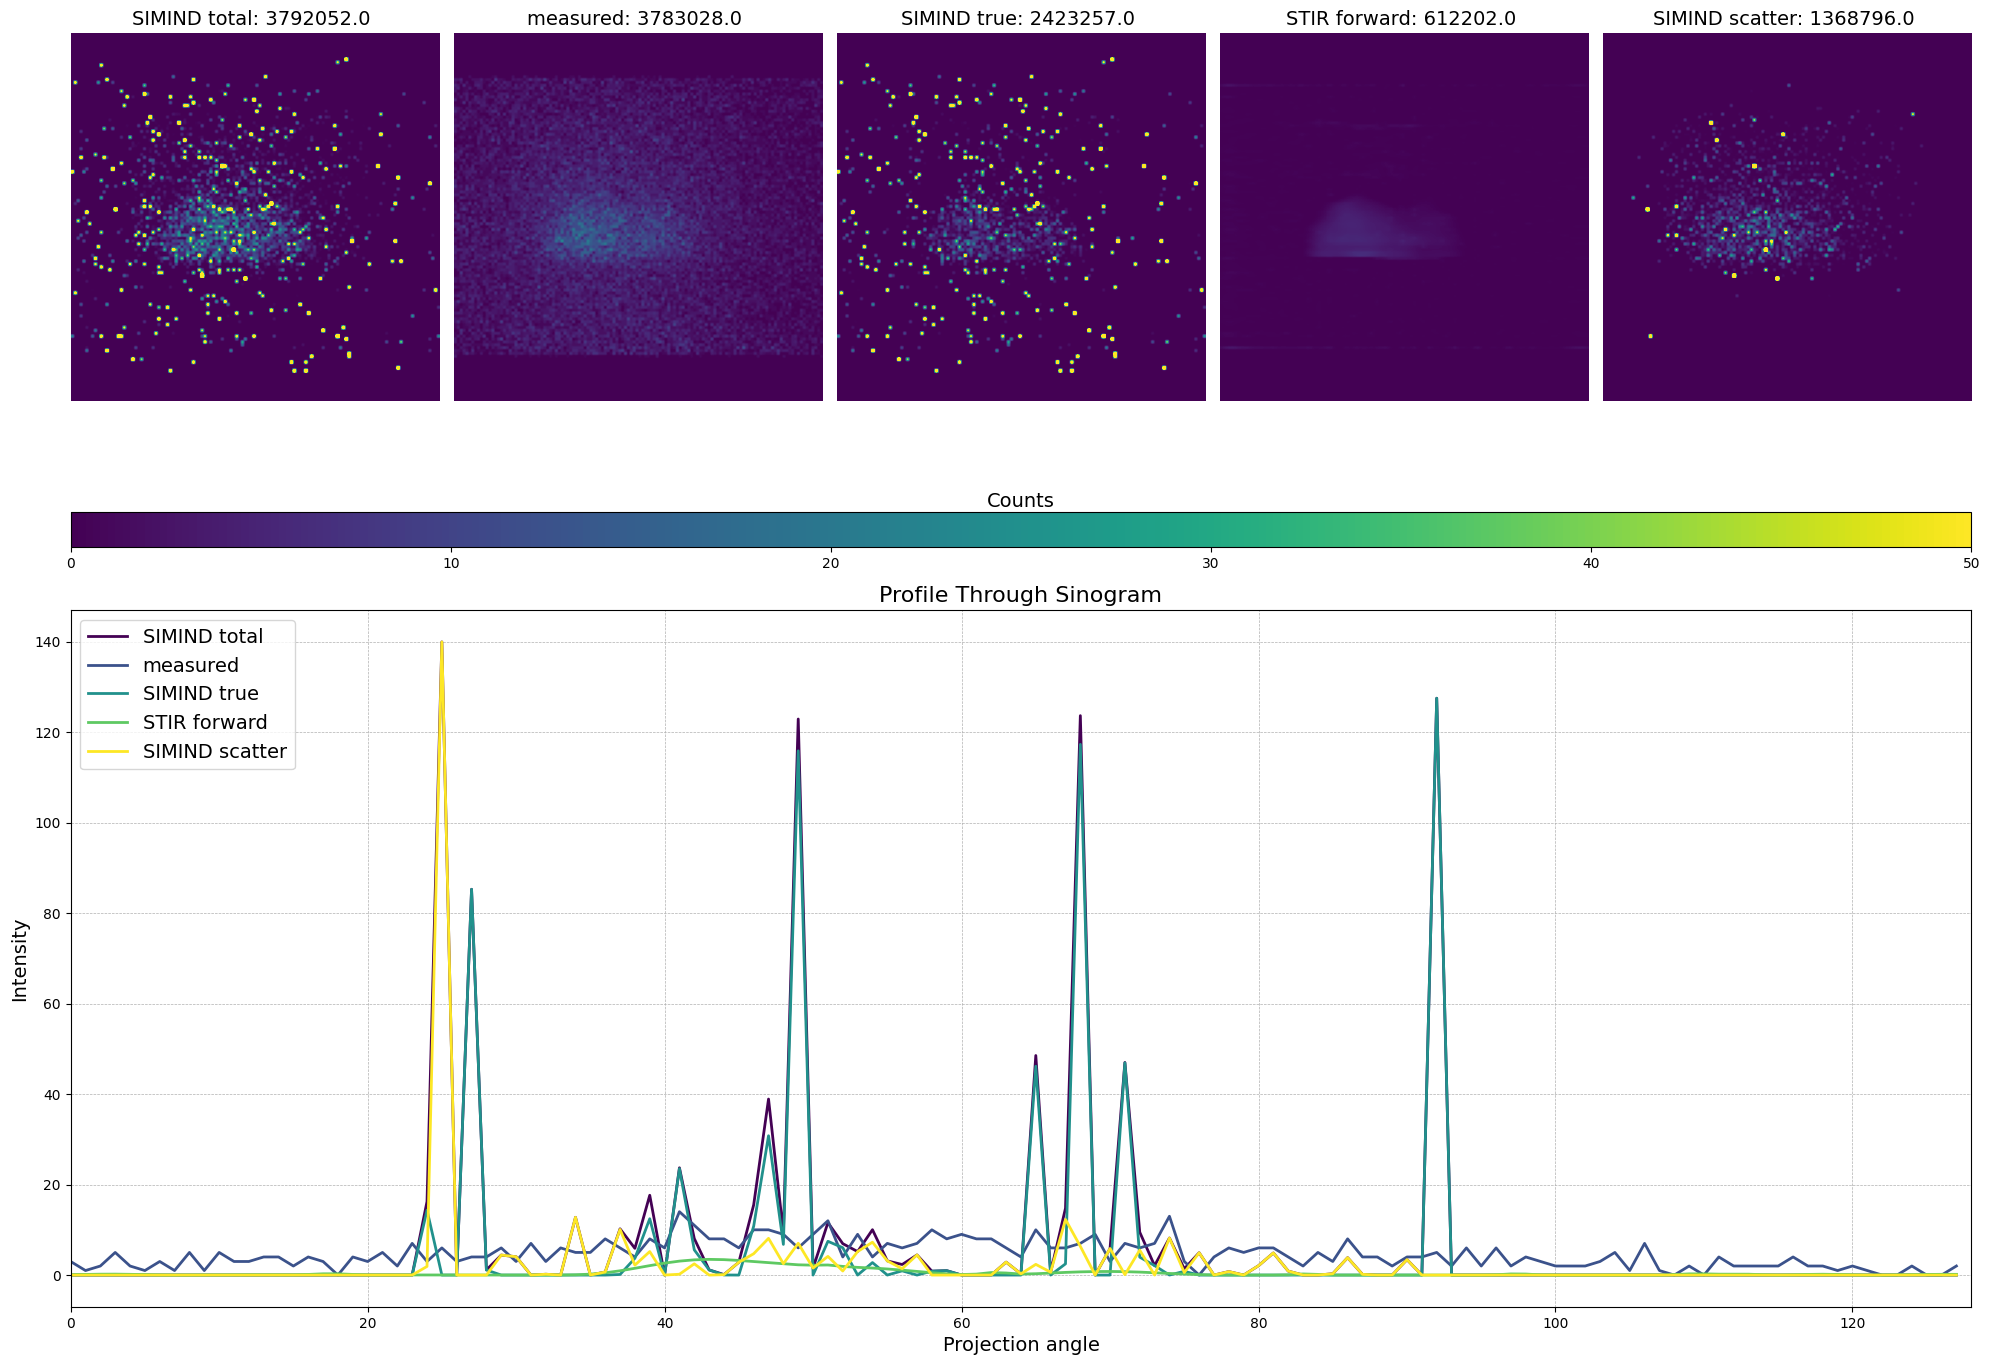

In [25]:
# Set the maximum intensity for color normalization
vmax = 100#max(measured_data.max(), simind_total.max(), stir_forward_projection.max())

# Create a figure and a GridSpec with 3 rows
fig = plt.figure(figsize=(len(data_list)*4,7*2,))
gs = GridSpec(3, len(data_list), height_ratios=[2, 0.15, 3])  # Adjusted GridSpec for clarity

# Create image subplots in the first row
ax_images = [fig.add_subplot(gs[0, i]) for i in range(len(data_list))]

for i, (data, title) in enumerate(data_list):
    im = ax_images[i].imshow(data[0, :, coronal_slice]/divisors[i], vmin=0, vmax=vmax/2, cmap=colormap)
    ax_images[i].set_title(f"{title}: {np.trunc(data.sum())} ", fontsize=font_size)
    ax_images[i].axis('off')

# Place a colorbar in a new row, just for the colorbar
cbar_ax = fig.add_subplot(gs[1, :])  # Spanning across the bottom of the image plots
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=0.02)  # Reduced padding
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.xaxis.set_label_position('top')

# Set consistent font size and line width for the line plot
line_width = 2

# Create line plot in the third row
ax_line = fig.add_subplot(gs[2, :])  # Spanning across both columns in the third row

# Plotting
# make colours eqwually spread out with length of data_list
colours = plt.cm.viridis(np.linspace(0, 1, len(data_list)))
for i, (data, title) in enumerate(data_list):
    #ax_line.plot(data[40], label=title, linewidth=line_width, color=colours[i], linestyle='--')
    ax_line.plot(data[0, 60, coronal_slice]/divisors[i], linewidth=line_width, color=colours[i], linestyle='-', label=title)
    #ax_line.plot(data[90], linewidth=line_width, color=colours[i], linestyle=':')

# Enhance the appearance of the line plot
ax_line.set_xlabel('Projection angle', fontsize=font_size)
ax_line.set_ylabel('Intensity', fontsize=font_size)
ax_line.set_title(f'Profile Through Sinogram', fontsize=font_size + 2)
ax_line.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_line.legend(loc='upper left', fontsize=font_size)
# et minimum and maximum values for x-axis
ax_line.set_xlim(0, 128)

# Adjust spacing and layout
plt.tight_layout()
plt.show()